In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import copy
from multiprocessing import Pool
from sklearn.metrics import roc_curve, auc
import sklearn
import time
import utils

In [2]:
import pickle
ratio=210
src_dir = './pu_data_ratio_Clarity' + str(ratio) +'/'
text_train = pickle.load(open(src_dir+'text_train_stratified.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train_stratified.pkl','rb'))
text_test = pickle.load(open(src_dir+'text_test_stratified.pkl','rb'))
label_test = pickle.load(open(src_dir+'label_test_stratified.pkl','rb'))

In [3]:
text_train.extend(text_test)
label_train.extend(label_test)
text_total = text_train
label_total = label_train

In [4]:
type(text_train)

list

In [5]:
# Convert splited sentence to documents. 
def back_to_doc(doc_list):
    new_doc_list = []
    for doc in doc_list:
        new_doc_list.append('')
        for sent in doc:
            new_doc_list[-1]+=' ' + str(sent)
    return new_doc_list
new_text_total = back_to_doc(text_total)

In [7]:
len(new_text_total)

9068

# Lemmatize the text

In [12]:
import pickle
ratio=2
src_dir = './pu_data_ratio_Clarity' + str(ratio) +'/'
text_train = pickle.load(open(src_dir+'text_train_stratified.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train_stratified.pkl','rb'))
train_len = len(text_train)
text_test = pickle.load(open(src_dir+'text_test_stratified.pkl','rb'))
label_test = pickle.load(open(src_dir+'label_test_stratified.pkl','rb'))
text_train.extend(text_test)
label_train.extend(label_test)
text_total = text_train
label_total = label_train
new_text_total = utils.back_to_doc(text_total)

In [13]:
import spacy
nlp = spacy.load('en',disable = ["parser", "ner"])
def lemma(doc):
    doc = nlp(doc)
    lemmatized_doc = ''
    for token in doc:
        if not token.lemma_ == '-PRON-':
            lemmatized_doc += ' ' + token.lemma_
    return lemmatized_doc

In [14]:
from tqdm import tqdm
lemmatized_text = []
for doc in tqdm(new_text_total):
    doc = lemma(doc)
    lemmatized_text.append(doc)

100%|██████████| 5913/5913 [04:51<00:00, 20.30it/s]


In [15]:
new_text_train = lemmatized_text[:train_len]
label_train = label_total[:train_len]
new_text_test = lemmatized_text[train_len:]
label_test = label_total[train_len:]

In [16]:
len(new_text_train)

4730

# RUN ML on lemmatized text

In [119]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8)
Tfidf_vectorizer = Tdidf_vectorizer.fit(new_text_total)

In [123]:
# Don't allow idf of testing data to be breached
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8)
Tfidf_vectorizer = Tdidf_vectorizer.fit(new_text_train)

In [124]:
X_train = Tfidf_vectorizer.transform(new_text_train)
y_train = label_train
X_test = Tfidf_vectorizer.transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

(4730, 122539)


In [129]:
def _svm_pipeline(global_idf):
    Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8)
    #--------------------Vectorize----------------------
    # Use the idf of whole text or only the idf of training dataset
    if global_idf:
        Tfidf_vectorizer = Tdidf_vectorizer.fit(new_text_total)
    else:
        Tfidf_vectorizer = Tdidf_vectorizer.fit(new_text_train)
    X_train = Tfidf_vectorizer.transform(new_text_train)
    y_train = label_train
    X_test = Tfidf_vectorizer.transform(new_text_test)
    y_test = label_test
    print(np.shape(X_train))
    #--------------------Training----------------------
    SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
    SVC_clf.fit(X_train,y_train)
    #--------------------Evaluation----------------------
    y_pred = SVC_clf.predict(X_test)

    y_pred_proba = SVC_clf.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba,axis=-1)

    print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
    print(metrics.confusion_matrix(y_test,y_pred))
    
    y_pred_prob2 = y_pred_proba[:,1]
    fpr,tpr,thres = roc_curve(y_test,y_pred_prob2)
    print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob2))
    return sklearn.metrics.roc_auc_score(y_test, y_pred_prob2)

In [17]:
start = time.time()
p = Pool(2)
auc_result = p.map(_svm_pipeline_1gram, range(2))
print(time.time() - start)
print(auc_result)

(4730, 15575)
(4730, 19106)
                   precision    recall  f1-score   support

No_pressure_ulcer       0.88      0.90      0.89       789
   pressure_ulcer       0.79      0.76      0.78       394

         accuracy                           0.85      1183
        macro avg       0.84      0.83      0.83      1183
     weighted avg       0.85      0.85      0.85      1183

[[709  80]
 [ 93 301]]
0.926267266281935
                   precision    recall  f1-score   support

No_pressure_ulcer       0.89      0.90      0.90       789
   pressure_ulcer       0.80      0.78      0.79       394

         accuracy                           0.86      1183
        macro avg       0.85      0.84      0.85      1183
     weighted avg       0.86      0.86      0.86      1183

[[712  77]
 [ 85 309]]
0.9288793242104314
298.75770568847656
[0.9288793242104314, 0.926267266281935]


In [145]:
start = time.time()
p = Pool(2)
auc_result = p.map(_svm_pipeline, range(2))
print(time.time() - start)
print(auc_result)

(17344, 351080)
(17344, 433428)
                   precision    recall  f1-score   support

No_pressure_ulcer       0.94      0.99      0.96      3943
   pressure_ulcer       0.73      0.40      0.52       394

         accuracy                           0.93      4337
        macro avg       0.84      0.69      0.74      4337
     weighted avg       0.92      0.93      0.92      4337

[[3884   59]
 [ 236  158]]
0.9218566347095863
                   precision    recall  f1-score   support

No_pressure_ulcer       0.94      0.99      0.96      3943
   pressure_ulcer       0.73      0.40      0.51       394

         accuracy                           0.93      4337
        macro avg       0.84      0.69      0.74      4337
     weighted avg       0.92      0.93      0.92      4337

[[3886   57]
 [ 238  156]]
0.923470688272348
7141.79450917244
[0.923470688272348, 0.9218566347095863]


Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/export/home/tzzhang/.pyenv/versions

In [146]:
auc_result

[0.923470688272348, 0.9218566347095863]

In [125]:
SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
SVC_clf.fit(X_train,y_train)
y_pred = SVC_clf.predict(X_test)

y_pred_proba = SVC_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.90      0.90      0.90       789
   pressure_ulcer       0.80      0.79      0.79       394

         accuracy                           0.86      1183
        macro avg       0.85      0.84      0.84      1183
     weighted avg       0.86      0.86      0.86      1183

[[709  80]
 [ 83 311]]


0.9342192455913481


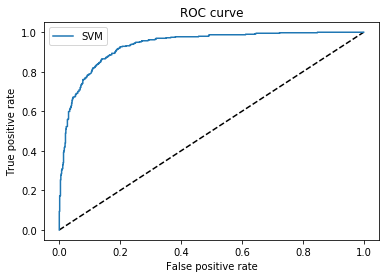

In [126]:
from sklearn.metrics import roc_curve, auc
import sklearn
y_pred_prob2 = y_pred_proba[:,1]
fpr,tpr,thres = roc_curve(y_test,y_pred_prob2)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob2))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
np.shape(Count_vec)

(21681, 433428)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Count_vec, label_total, test_size=0.2, random_state=42,stratify=label_total)
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.97      0.83      0.90      3943
   pressure_ulcer       0.31      0.76      0.44       394

         accuracy                           0.83      4337
        macro avg       0.64      0.80      0.67      4337
     weighted avg       0.91      0.83      0.86      4337



In [16]:
X_train, X_test, y_train, y_test = train_test_split(Count_vec, label_total, test_size=0.2, random_state=42)
clf = ComplementNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.97      0.84      0.90      3940
   pressure_ulcer       0.32      0.76      0.45       397

         accuracy                           0.83      4337
        macro avg       0.65      0.80      0.68      4337
     weighted avg       0.91      0.83      0.86      4337



In [17]:
metrics.confusion_matrix(y_test,y_pred)

array([[3308,  632],
       [  95,  302]])

In [18]:
metrics.f1_score(y_test,y_pred)

0.4537941397445529

In [ ]:
svm.SVC(gamma='scale')

In [ ]:
# Grid Search for NB parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline_helper import PipelineHelper
X = new_text_total
Y = label_total
pipe = Pipeline([
    ('vectorizer', PipelineHelper([
        ('count', CountVectorizer(stop_words='english'),
        ('tfidf', TfidfVectorizer(stop_words='english'),
    ])),
    ('classifier', PipelineHelper([
        ('Multinomial', MultinomialNB()),
        ('Complement', ComplementNB()),
    ])),
])

params = {
    'vectorizer__selected_model': pipe.named_steps['vectorizer'].generate({
        'count__ngram_range': [(1,1),(1,2),(1,3)],
        'count__min_df': [5,10],
        'count__max_df': [0.4,0.6,0.8],
        'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
        'tfidf__min_df':[5,10],
        'tfidf__max_df':[0.4,0.6,0.8],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'Multinomial__alpha': [1.0],
        'Complement__alpha': [1.0],
    })
}
grid = GridSearchCV(pipe, params, scoring='accuracy', verbose=1,cv=5,n_jobs=-1)
grid.fit(X, Y)
print(grid.best_params_)
print(grid.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.6min


In [20]:
print(grid.best_params_)

{'vectorizer__selected_model': ('tfidf', {'min_df': 10, 'ngram_range': (1, 1), 'max_df': 0.4}), 'classifier__selected_model': ('Multinomial', {'alpha': 1.0})}


In [9]:
Tfidf_vectorizer =TfidfVectorizer(ngram_range=(1,1),min_df =10,stop_words='english',token_pattern=r"(?u)\b\d?[a-z]{2,}\d?\b",max_df = 0.8)
Tfidf_vec = Tfidf_vectorizer.fit_transform(new_text_total)
print(np.shape(Tfidf_vec))
X_train, X_test, y_train, y_test = train_test_split(Tfidf_vec, label_total, test_size=0.2, random_state=41)
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','ressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred))

(7884, 13921)
                   precision    recall  f1-score   support

No_pressure_ulcer       0.82      0.96      0.89      1170
    ressure_ulcer       0.79      0.41      0.54       407

         accuracy                           0.82      1577
        macro avg       0.80      0.69      0.71      1577
     weighted avg       0.81      0.82      0.80      1577

[[1124   46]
 [ 239  168]]


                   precision    recall  f1-score   support

No_pressure_ulcer       0.86      0.88      0.87       797
    ressure_ulcer       0.74      0.69      0.72       386

         accuracy                           0.82      1183
        macro avg       0.80      0.79      0.79      1183
     weighted avg       0.82      0.82      0.82      1183

[[704  93]
 [119 267]]

# 正常SVM

In [6]:
import pickle
ratio=2
src_dir = './pu_data_ratio_Clarity' + str(ratio) +'/'
text_train = pickle.load(open(src_dir+'text_train_stratified.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train_stratified.pkl','rb'))
text_test = pickle.load(open(src_dir+'text_test_stratified.pkl','rb'))
label_test = pickle.load(open(src_dir+'label_test_stratified.pkl','rb'))
text_train.extend(text_test)
label_train.extend(label_test)
text_total = text_train
label_total = label_train
new_text_total = utils.back_to_doc(text_total)
text_train = pickle.load(open(src_dir+'text_train_stratified.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train_stratified.pkl','rb'))
new_text_train = utils.back_to_doc(text_train)
new_text_test = utils.back_to_doc(text_test)

In [9]:
def _svm_pipeline_1gram(global_idf):
    Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),min_df =5,stop_words='english',max_df = 0.8)
    #--------------------Vectorize----------------------
    # Use the idf of whole text or only the idf of training dataset
    if global_idf:
        Tfidf_vectorizer = Tfidf_vectorizer.fit(new_text_total)
    else:
        Tfidf_vectorizer = Tfidf_vectorizer.fit(new_text_train)
    X_train = Tfidf_vectorizer.transform(new_text_train)
    y_train = label_train
    X_test = Tfidf_vectorizer.transform(new_text_test)
    y_test = label_test
    print(np.shape(X_train))
    #--------------------Training----------------------
    SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
    SVC_clf.fit(X_train,y_train)
    #--------------------Evaluation----------------------
    y_pred = SVC_clf.predict(X_test)

    y_pred_proba = SVC_clf.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba,axis=-1)

    print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
    print(metrics.confusion_matrix(y_test,y_pred))
    
    y_pred_prob2 = y_pred_proba[:,1]
    fpr,tpr,thres = roc_curve(y_test,y_pred_prob2)
    print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob2))
    return sklearn.metrics.roc_auc_score(y_test, y_pred_prob2)

In [10]:
start = time.time()
p = Pool(2)
auc_result = p.map(_svm_pipeline_1gram, range(2))
print(time.time() - start)
print(auc_result)

(4730, 17292)
(4730, 19106)
                   precision    recall  f1-score   support

No_pressure_ulcer       0.89      0.90      0.89       789
   pressure_ulcer       0.79      0.78      0.78       394

         accuracy                           0.86      1183
        macro avg       0.84      0.84      0.84      1183
     weighted avg       0.86      0.86      0.86      1183

[[709  80]
 [ 88 306]]
0.926978183526021
                   precision    recall  f1-score   support

No_pressure_ulcer       0.89      0.90      0.90       789
   pressure_ulcer       0.80      0.78      0.79       394

         accuracy                           0.86      1183
        macro avg       0.84      0.84      0.84      1183
     weighted avg       0.86      0.86      0.86      1183

[[711  78]
 [ 88 306]]
0.9270425199282005
319.71243834495544
[0.926978183526021, 0.9270425199282005]


In [106]:
len(new_text_total)

5913

In [107]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8)
Tfidf_vectorizer = Tdidf_vectorizer.fit(new_text_total)

In [108]:
#Tfidf_vectorizer =TfidfVectorizer(ngram_range=(1,2),min_df =5,stop_words='english',max_df = 0.8,vocabulary = whole_vocab)
X_train = Tfidf_vectorizer.transform(new_text_train)
y_train = label_train
X_test = Tfidf_vectorizer.transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

(4730, 149922)


In [19]:
clf2 = svm.SVC(kernel = 'linear',gamma = 'scale')
clf2.fit(X_train,y_train)
y_pred = clf2.predict(X_test)

In [70]:
print(grid.best_params_)
print(grid.best_score_)

{'vectorizer__selected_model': ('tfidf', {'max_df': 0.4, 'min_df': 5, 'ngram_range': (1, 2)}), 'classifier__selected_model': ('Linear_SVM', {'class_weight': 'balanced'})}
0.8001768844593624


In [57]:
X_train, X_test, y_train, y_test = train_test_split(Tdidf_vec, label_total, test_size=0.2, random_state=42,stratify=label_total)

(5913, 149922)


In [60]:
np.shape(X_train)

(4730, 149922)

In [109]:
SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
SVC_clf.fit(X_train,y_train)
y_pred = SVC_clf.predict(X_test)

y_pred_proba = SVC_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.89      0.90      0.90       789
   pressure_ulcer       0.80      0.79      0.79       394

         accuracy                           0.86      1183
        macro avg       0.85      0.84      0.85      1183
     weighted avg       0.86      0.86      0.86      1183

[[711  78]
 [ 84 310]]


0.9326397869178359


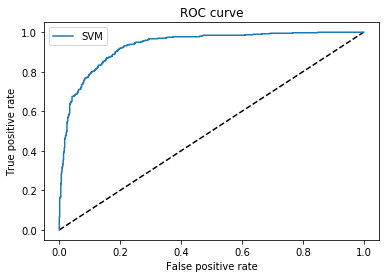

In [110]:
from sklearn.metrics import roc_curve, auc
import sklearn
y_pred_prob2 = y_pred_proba[:,1]
fpr,tpr,thres = roc_curve(y_test,y_pred_prob2)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_prob2))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [30]:
print(metrics.classification_report(y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.93      0.99      0.96      3940
   pressure_ulcer       0.70      0.27      0.39       397

         accuracy                           0.92      4337
        macro avg       0.82      0.63      0.67      4337
     weighted avg       0.91      0.92      0.91      4337

[[3895   45]
 [ 290  107]]


In [32]:
y_pred_proba

array([[0.75815417, 0.24184583],
       [0.35019152, 0.64980848],
       [0.96622018, 0.03377982],
       ...,
       [0.9179925 , 0.0820075 ],
       [0.96096659, 0.03903341],
       [0.94485377, 0.05514623]])

In [31]:
metrics.f1_score(y_test,y_pred)

0.38979963570127507

In [34]:
np.shape(y_test)

(4337,)

In [35]:
np.shape(y_pred_proba)

(4337, 2)

In [36]:
y_pred_pos_proba = y_pred_proba[:,1]

In [38]:
y_pred_pos_proba

array([0.24184583, 0.64980848, 0.03377982, ..., 0.0820075 , 0.03903341,
       0.05514623])

In [37]:
import sklearn
sklearn.metrics.roc_auc_score(y_test, y_pred_pos_proba)

0.8731776394021149

In [40]:
fpr,tpr,thres = sklearn.metrics.roc_curve(y_test,y_pred_pos_proba)
fpr_20bert = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/fpr.npy')
tpr_20bert = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/tpr.npy')

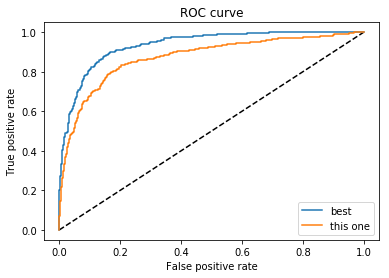

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_20bert, tpr_20bert, label='best')
plt.plot(fpr, tpr, label='this one')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [23]:
import tools
import imp
imp.reload(tools)
pos_words = tools.show_word(Tdidf_vectorizer,SVC_clf,200,words_count,count_thres = 20,for_pos = True)
print(pos_words)

NameError: name 'Tdidf_vectorizer' is not defined

In [27]:
import tools
import imp
imp.reload(tools)
pos_words = tools.show_word(Count_vectorizer,SVC_clf,200,words_count,count_thres = 20,for_pos = True)
print(pos_words)

0.09206149367533677
['rehab stay', 'fromon', 'discharged fromon', 'read', 'facility rehabilitation', 'physician discharge', 'health discharge', 'attending', 'diagnosis congestive', 'failure systolic', 'penicillins heparin', 'facility healthcare', 'ulcer', 'pressure ulcer', 'patient dnr', 'decubitus', 'cxr stable', 'home health', 'healthcare center', '30 days', 'stable unchanged', 'attending physician', 'checked negative', 'dx', 'hiv antibody', 'stable cxr', 'urology allergies', 'service urology', 'antibody test', 'discharge md', 'disposition extended', 'thursdayat 20', 'thursdayat', 'md discharge', 'pm discharge', 'patient stable', 'stage', 'physician', 'facility nursing', 'appointment dr', 'coccyx', 'dr arranged', 'attending addendum', 'failed', 'arranged', 'included', 'lasix decreased', 'decreased 20', 'negative discharge', 'sacral', 'failed improve', 'improve patient', 'chronic acute', 'discharge discharge', 'clinic notes', 'betweenand', 'amoxicillin attending', 'discharged coumadin

In [28]:
neg_words = tools.show_word(Tdidf_vectorizer,SVC_clf,200,words_count,count_thres = 50,for_pos = False)
print(neg_words)

NameError: name 'Tdidf_vectorizer' is not defined

In [29]:
neg_words = tools.show_word(Count_vectorizer,SVC_clf,200,words_count,count_thres = 50,for_pos = False)
print(neg_words)

0.05714287838089768
['length stay', 'expected', 'length', 'awaiting', 'neurosurgery', 'disposition homemdcompleted', 'added', 'homemdcompleted', 'failure discharge', 'service neurosurgery', 'neurosurgery allergies', 'alprazolam', 'medications discharge', 'care discharge', 'service neurology', 'neurology allergies', 'opposed', 'update', 'paperwork', 'pentoxifylline', 'care physician', 'discharge medication', 'continued home', 'allergies morphine', 'dictated', 'recommendations included', 'supplemental oxygen', 'results', 'ritalin', 'nursing center', 'care recommendations', 'changed', 'overnight', 'health care', 'clarify', 'code discharge', 'status code', 'supplemental', 'ultram', 'facility house', 'addendum note', 'patient referred', 'pending', 'medication list', 'discharge paperwork', 'course discharge', 'codeine attending', 'aggrenox', 'aspiration pneumonia', 'void', 'end stage', 'information', 'home discharge', 'phone', 'sepsis', 'evaluated neurosurgery', 'carbonate', 'recs', 'appt dr

# 训练测试比例不同实验

In [11]:
import pickle
ratio=210
src_dir = './pu_data_ratio_Clarity' + str(ratio) +'/'
text_train = pickle.load(open(src_dir+'text_train_stratified.pkl','rb'))
label_train = pickle.load(open(src_dir+'label_train_stratified.pkl','rb'))
text_test = pickle.load(open(src_dir+'text_test_stratified.pkl','rb'))
label_test = pickle.load(open(src_dir+'label_test_stratified.pkl','rb'))
new_text_train = back_to_doc(text_train)
new_text_test = back_to_doc(text_test)

In [11]:
Tdidf_vectorizer_1gram =TfidfVectorizer(ngram_range=(1,1),min_df =10,stop_words='english',max_df = 0.8,token_pattern=r"(?u)\b\d?[a-z]{2,}\d?\b")
Tdidf_vec_1gram = Tdidf_vectorizer_1gram.fit_transform(new_text_total)
print(np.shape(Tdidf_vec_1gram))
Tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,1),min_df =10,stop_words='english', \
                                    max_df = 0.8,token_pattern=r"(?u)\b\d?[a-z]{2,}\d?\b",vocabulary = Tdidf_vectorizer_1gram.vocabulary_)
X_train = Tfidf_vectorizer2.fit_transform(new_text_train)
y_train = label_train
X_test = Tfidf_vectorizer2.fit_transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

(7884, 13921)
(6307, 13921)


In [14]:
Tdidf_vectorizer_2gram =TfidfVectorizer(ngram_range=(1,2),min_df =10,stop_words='english',max_df = 0.8,token_pattern=r"(?u)\b\d?[a-z]{2,}\d?\b")
Tdidf_vec_2gram = Tdidf_vectorizer_2gram.fit_transform(new_text_total)
print(np.shape(Tdidf_vec_2gram))
Tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,2),min_df =10,stop_words='english', \
                                    max_df = 0.8,token_pattern=r"(?u)\b\d?[a-z]{2,}\d?\b",vocabulary = Tdidf_vectorizer_2gram.vocabulary_)
X_train = Tfidf_vectorizer2.fit_transform(new_text_train)
y_train = label_train
X_test = Tfidf_vectorizer2.fit_transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

(9068, 95653)
(4731, 95653)


In [15]:
print(np.shape(X_test))

(4337, 95653)


In [ ]:
# Grid Search for SVC parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline_helper import PipelineHelper
X = new_text_total
Y = label_total
pipe = Pipeline([
    ('vectorizer', PipelineHelper([
        ('count', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfVectorizer(stop_words='english')),
    ])),
    ('classifier', PipelineHelper([
        ('SVC', svm.SVC()),
    ])),
])

params = {
    'vectorizer__selected_model': pipe.named_steps['vectorizer'].generate({
        'count__ngram_range': [(1,1),(1,2),(1,3)],
        'count__min_df': [5,10],
        'count__max_df': [0.4,0.6,0.8],
        'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
        'tfidf__min_df':[5,10],
        'tfidf__max_df':[0.4,0.6,0.8],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
    })
}
grid = GridSearchCV(pipe, params, scoring='accuracy', verbose=1,cv=5,n_jobs=-1)
grid.fit(X, Y)
print(grid.best_params_)
print(grid.best_score_)


In [ ]:
clf_1gram = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
clf_1gram.fit(X_train,y_train)
y_pred = clf_1gram.predict(X_test)

y_pred_proba = clf_1gram.predict_proba(X_test)
y_pred_proba = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred_proba, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred_proba))

In [18]:
clf_2gram = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
clf_2gram.fit(X_train,y_train)
y_pred = clf_2gram.predict(X_test)

y_pred_proba = clf_2gram.predict_proba(X_test)
y_pred_proba = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred_proba, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred_proba))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.98      0.87      0.92      3943
   pressure_ulcer       0.38      0.78      0.52       394

         accuracy                           0.87      4337
        macro avg       0.68      0.83      0.72      4337
     weighted avg       0.92      0.87      0.89      4337

[[3446  497]
 [  85  309]]


In [19]:
y_pred_proba = clf_2gram.predict_proba(X_test)

In [23]:
np.shape(y_pred_proba)

(4337, 2)

In [35]:
y_pred_pos_proba =  y_pred_proba[:,1]

In [36]:
from sklearn.metrics import roc_curve, auc
import sklearn
fpr,tpr,thres = roc_curve(y_test,y_pred_pos_proba)
sklearn.metrics.roc_auc_score(y_test, y_pred_pos_proba)

0.9194054618413922

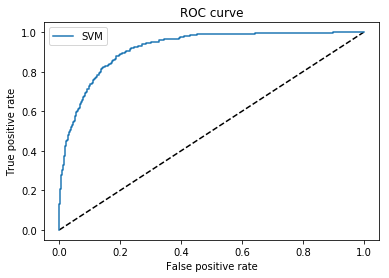

In [37]:
from sklearn.metrics import roc_curve, auc
import sklearn
fpr,tpr,thres = roc_curve(y_test,y_pred_pos_proba)
print(sklearn.metrics.roc_auc_score(y_test, y_pred_pos_proba))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
from sklearn.externals import joblib
joblib.dump(clf_2gram,'2ratio_svm.model')

/export/home/tzzhang/.pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['2ratio_svm.model']

In [ ]:
X_test = Tfidf_vectorizer2.fit_transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

In [15]:
print(np.shape(X_train))

(6307, 13921)


In [14]:
print(metrics.classification_report(y_test, y_pred_proba, target_names=['No_pressure_ulcer','pressure_ulcer']))


                   precision    recall  f1-score   support

No_pressure_ulcer       0.90      0.94      0.92      1195
   pressure_ulcer       0.79      0.66      0.72       382

         accuracy                           0.88      1577
        macro avg       0.84      0.80      0.82      1577
     weighted avg       0.87      0.88      0.87      1577



In [13]:
metrics.f1_score(y_test,y_pred_proba)

0.7226173541963015

In [18]:
import tools
import imp
imp.reload(tools)
pos_words = tools.show_word(Tdidf_vectorizer_1gram,clf_1gram,200,words_count,count_thres = 20,for_pos = True)
print(pos_words)

0.6944779028129857
['ulcer', 'sacral', 'decubitus', 'stage', 'ulcers', 'wound', 'extended', 'skin', 'rehab', 'eeg', 'ml', 'medicine', 'developed', '5mg', 'picc', 'zosyn', 'addendum', 'facility', 'cancer', 'failed', 'vancomycin', 'noted', 'attending', 'event', 'recent', 'slowly', 'cervical', 'transfusions', 'hr', 'ostomy', 'mdcompleted', 'topical', 'le', 'consulted', 'failure', 'hospice', 'prolonged', 'catheter', 'tracheostomy', 'long', 'residual', 'uti', 'maintain', 'oxycodone', 'pseudomonas', 'meropenem', 'ii', 'peg', 'thought', 'poor', 'limited', 'chronic', 'metabolic', 'femoral', 'groin', 'bowel', 'vanco', 'bilateral', 'ischemic', 'troponin', 'study', 'rapid', 'underlying', 'recommendations', 'nrb', 'transitioned', 'brought', 'portal', 'physician', 'senna', 'note', 'appl', 'indicated', 'staph', 'dilaudid', 'ipratropium', 'obstruction', 'elevated', 'current', 'cholecystitis', 'knee', 'mm', 'shift', 'ultimately', 'diff', 'resp', 'treated', 'cabg', 'rib', 'bactrim', 'drainage', 'pressu

In [19]:
neg_words = tools.show_word(Tdidf_vectorizer_1gram,clf_1gram,200,words_count,count_thres = 20,for_pos = False)
print(neg_words)

0.5272496462742593
['dictated', 'job', 'independent', 'clinic', 'normal', 'headache', 'ambulatory', 'calcium', 'lactulose', 'size', 'pending', 'cardiothoracic', 'airway', 'ranitidine', 'tablets', 'qd', 'department', 'dyspnea', 'patent', 'infection', 'wave', 'start', 'neurosurgery', 'pain', 'fluids', 'goal', 'small', 'lasix', 'diarrhea', 'hypertension', 'lisinopril', 'old', 'weakness', 'breast', 'graft', 'decrease', 'levofloxacin', 'intensive', 'previous', 'morning', 'coherent', 'drawn', 'wheezing', 'ambulating', 'question', 'went', 'cerebral', 'inweeks', 'seizures', 'simvastatin', 'laboratory', 'floor', 'revealed', 'stable', 'etiology', 'stenting', 'clopidogrel', 'taken', 'arteries', 'gait', 'children', 'neurologic', 'vna', 'evidence', 'esophageal', 'release', 'tolerated', 'amlodipine', 'stop', 'tenderness', 'hyponatremia', 'hcl', 'pounds', 'hand', 'body', 'given', 'lungs', 'denies', 'diastolic', 'supple', 'peep', 'monitored', 'hematology', 'oxygen', 'symptoms', 'constipation', 'oral',

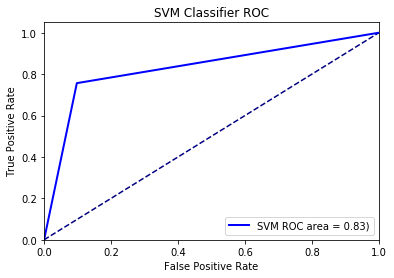

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
#GET ROC DATA
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
#GRAPH DATA
plt.figure(1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('SVM Classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [17]:
Count_vectorizer2 = CountVectorizer(ngram_range=(1,1),min_df =5,stop_words='english', \
                                    max_df = 0.4,vocabulary = Tdidf_vectorizer_1gram.vocabulary_)
X_train = Count_vectorizer2.fit_transform(new_text_train)
y_train = label_train
X_test = Count_vectorizer2.fit_transform(new_text_test)
y_test = label_test
print(np.shape(X_train))

(4730, 36251)


In [25]:
words_count = np.sum(X_train,axis=0)
words_count += np.sum(X_test,axis=0)

In [26]:
np.shape(words_count)

(1, 436831)

In [22]:
Tdidf_vec_1gram

<21681x36251 sparse matrix of type '<class 'numpy.float64'>'
	with 8695434 stored elements in Compressed Sparse Row format>

In [27]:
words_count[0,5]

3

In [51]:
import tools
import imp
imp.reload(tools)
pos_words = tools.show_word(Tdidf_vectorizer_1gram,clf_1gram,200,words_count,count_thres = 20,for_pos = True)
print(pos_words)

0.7584702253326446
['ulcer', 'sacral', 'decubitus', 'ulcers', 'extended', 'coccyx', 'rehab', 'stage', 'wound', 'eeg', 'addendum', 'cancer', 'skin', 'decub', 'failed', 'mdcompleted', 'wheelchair', 'q6h', 'unchanged', 'le', 'solution', 'heel', '5mg', 'developed', 'consulted', 'hospice', 'neuropathy', 'zosyn', 'cva', 'expired', 'picc', 'penicillins', 'failure', 'moderate', 'topical', 'cholecystitis', '300', 'treatment', 'meropenem', 'cervical', 'line', 'appl', 'ii', 'paraplegia', 'troponin', 'large', 'caltco2', 'institution', 'infected', '09am', '44pm', 'hypernatremia', 'tibial', 'diff', 'klebsiella', 'tid', 'intubation', 'porcine', 'zinc', 'senna', 'rib', 'groin', 'foley', 'ascorbic', 'nursing', 'midodrine', 'dissolve', 'dc', 'sacrum', 'histroy', 'mirtazapine', '05', 'rvr', '28', 'dependent', 'high', 'tricuspid', 'drainage', 'complicated', 'x2', 'retention', 'cryptogenic', '27', 'pressures', 'stump', 'cast', 'transfusions', 'counts', 'recent', '143', 'prolonged', 'sc', 'obtain', 'related

In [53]:
neg_words = tools.show_word(Tdidf_vectorizer_1gram,clf_1gram,200,words_count,count_thres = 20,for_pos = False)
print(neg_words)

0.6210676611234992
['job', 'medquist36', 'dictated', 'size', '6h', 'qd', 'q4', 'airway', 'graft', 'patent', 'headache', 'independent', 'med', 'pending', 'lactulose', '45', 'thalamic', '95', 'lisinopril', 'peritoneal', 'nitro', 'amlodipine', 'bleed', 'tobacco', 'examination', '09pm', 'pounds', 'rashes', 'dyspnea', 'cerebral', '20am', 'ejection', 'approximately', 'ambulatory', 'carbonate', 'outpatient', 'infiltrate', 'intensive', 'tests', 'tamponade', '42', 'hernia', 'tablets', 'hcl', 'hyponatremia', 'staphylococcus', 'neurosurgery', 'diet', 'captopril', 'advised', 'phone', 'pd', '24hr', 'fluticasone', 'block', 'presence', 'vomiting', 'levo', 'bld', 'woman', 'tomorrow', 'bicarbonate', 'bright', 'wave', 'changed', 'acetabular', 'stairs', 'pelvis', 'campus', 'nasogastric', 'ventral', 'infor', 'losartan', 'dysarthria', 'orthopedic', 'twice', 'ambulating', 'cardiothoracic', 'pta', 'blocker', 'protonix', 'children', 'arm', 'flutter', 'etiology', 'dye', 'hypertrophy', 'data', 'igg', 'lateral',

In [54]:
imp.reload(tools)
tools.vocab_prep(pos_words,neg_words)

In [103]:
X_train = Tfidf_vectorizer2.fit_transform(new_text_train)
y_train = label_train
X_test = Tfidf_vectorizer2.fit_transform(new_text_test)
y_test = label_test

In [ ]:
X_train_normed = X_train / np.sum(X_train,axis=-1) 
X_test_normed = X_test / np.sum(X_test,axis=-1) 
print(np.sum(X_train_normed[0,:]))
print(np.shape(X_train_normed))

In [104]:
def feature_scaling(X):
    X = X.todense()
    normed_X = np.zeros_like(X)
    min_array = np.min(X,axis=-1)
    max_array = np.max(X,axis=-1)
    for i in range(np.shape(X)[0]):
        normed_X[i,:] = (X[i,:] - min_array[i]) / (max_array[i] - min_array[i])
    return normed_X
        

In [105]:
X_train_normed = feature_scaling(X_train)
X_test_normed =feature_scaling(X_test)# (X_test - np.min(X_test,axis=-1)) / (np.max(X_test,axis=-1) - np.min(X_test,axis=-1))
print(np.sum(X_train_normed[0,:]))
print(np.shape(X_train_normed))

68.07648285581799
(4730, 21020)


In [106]:
clf_1gram_norm = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
clf_1gram_norm.fit(X_train_normed,y_train)

y_pred_proba = clf_1gram_norm.predict_proba(X_test_normed)
y_pred_proba = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred_proba, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred_proba))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.85      0.90      0.88       797
   pressure_ulcer       0.77      0.68      0.72       386

         accuracy                           0.83      1183
        macro avg       0.81      0.79      0.80      1183
     weighted avg       0.82      0.83      0.82      1183

[[717  80]
 [124 262]]


In [10]:
clf_1gram = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
clf_1gram.fit(X_train,y_train)
y_pred = clf_1gram.predict(X_test)

y_pred_proba = clf_1gram.predict_proba(X_test)
y_pred_proba = np.argmax(y_pred_proba,axis=-1)

print(metrics.classification_report(y_test, y_pred_proba, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(metrics.confusion_matrix(y_test,y_pred_proba))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.81      0.91      0.86       797
   pressure_ulcer       0.76      0.57      0.65       386

         accuracy                           0.80      1183
        macro avg       0.79      0.74      0.76      1183
     weighted avg       0.80      0.80      0.79      1183

[[729  68]
 [167 219]]


In [88]:
plt.show()

In [12]:
len(pos_words)

50

In [13]:
pos_words

['klebsiella',
 'sacral',
 'decreased',
 'ofmdcompleted',
 'saw',
 'nature',
 'trache',
 'latex',
 'indefinitely',
 'recorded',
 'oncology',
 'vaccine',
 'duoderm',
 'sirs',
 'demerol',
 'ulcers',
 'drugs',
 'betweenand',
 '81mg',
 'agents',
 'healthcare',
 'read',
 'failed',
 'bandages',
 'neurologist',
 'peaked',
 'ulcer',
 'hiv',
 'penicillins',
 'presumed',
 'conveyed',
 'nursing',
 'meningitis',
 'rehab',
 'decubitus',
 'md',
 'fromon',
 'antibody',
 'dx',
 'insurance',
 'coccyx',
 'stage',
 'gent',
 'congestive',
 'pepcid',
 'physician',
 'eeg',
 'caremdcompleted',
 'toon',
 'mdcompleted']

In [14]:
neg_words

['pneumothorax',
 'hemodynamic',
 'tab',
 'list',
 'dilantin',
 'nitrofurantoin',
 'tests',
 'therapeutic',
 'neurology',
 'og',
 'reglan',
 'life',
 'size',
 'fax',
 'number',
 'stitches',
 'maintained',
 'spent',
 'called',
 'cefazolin',
 'inclinic',
 'drawn',
 'blocking',
 'needs',
 'benadryl',
 'cerebral',
 'resultant',
 'changed',
 'garden',
 'represented',
 'chips',
 'pod6',
 'peak',
 'conceivably',
 'neurosurgery',
 'correct',
 'court',
 'cardiothoracic',
 'monitored',
 'meq',
 'medquist36',
 'homemdcompleted',
 'hydrocodone',
 'verified',
 'transient',
 'job',
 'dictated',
 'ice',
 'aged',
 'oob']

In [79]:
num=200
important_word_index = np.argpartition(coef,-num)[0,-num:]

In [74]:
important_word_index.tolist()[0]

[4169,
 14019,
 6485,
 469,
 14492,
 6528,
 5335,
 3982,
 12710,
 2853,
 13491,
 10458,
 7531,
 10451,
 693,
 3187,
 9412,
 11650,
 1893,
 11725,
 4186,
 5283,
 2162,
 14451,
 2088,
 3042,
 519,
 7389,
 10762,
 2031,
 4073,
 8678,
 6352,
 10631,
 5408,
 11057,
 3359,
 7365,
 2383,
 62,
 14222,
 13531,
 7479,
 5191,
 2006,
 12666,
 5198,
 11677,
 4139,
 4404,
 3671,
 817,
 8509,
 5803,
 4860,
 1554,
 7750,
 8767,
 11238,
 3330,
 6155,
 6762,
 8520,
 13641,
 12563,
 10056,
 10577,
 11930,
 8346,
 13829,
 14003,
 6957,
 10760,
 11860,
 12296,
 281,
 9471,
 10582,
 7403,
 2534,
 9225,
 2491,
 3405,
 797,
 8017,
 3420,
 8744,
 13879,
 10474,
 9443,
 4538,
 1226,
 9831,
 6907,
 10982,
 4537,
 11175,
 12734,
 10389,
 14471,
 4532,
 2686,
 9480,
 10472,
 4528,
 9436,
 13472,
 13622,
 4205,
 3937,
 10099,
 1495,
 608,
 4784,
 8588,
 14377,
 5490,
 3160,
 3747,
 11594,
 11309,
 8715,
 12062,
 5890,
 3154,
 7078,
 2875,
 13802,
 11601,
 12321,
 4767,
 9298,
 13804,
 7877,
 11441,
 1346,
 8603,
 1

In [72]:
np.shape(coef[0])

(1, 14572)

In [76]:
np.shape(important_word_index)

(1, 200)

In [21]:
# test for reverse
a = np.random.random((1,1000))
print(a)

[[5.86067458e-01 2.92969513e-01 4.74585611e-01 8.53704063e-01
  8.53924145e-01 2.01365132e-02 4.91993867e-01 1.92194369e-01
  5.82830364e-01 8.40463601e-01 9.60270445e-01 5.54859401e-01
  6.73639713e-01 2.62294174e-01 4.16429261e-01 9.72951806e-01
  4.74302172e-01 4.27831011e-01 5.85554223e-01 6.06118638e-01
  1.55307370e-01 8.43082487e-01 9.24948215e-01 4.05933444e-01
  1.34340235e-01 3.47627509e-01 7.69452937e-01 5.84526135e-01
  3.22761071e-01 3.86712462e-01 2.31672555e-01 8.35420562e-01
  9.04713302e-01 3.64458877e-01 1.76847215e-01 1.82108329e-01
  3.04034335e-01 7.24781834e-01 3.83627156e-01 6.17998336e-01
  8.59577864e-01 4.83431745e-01 2.58678388e-01 4.44140279e-01
  6.47573729e-01 1.30471835e-01 3.32257480e-01 9.95231689e-01
  8.12030574e-01 5.85507871e-01 2.53054451e-01 9.99516870e-01
  5.40382806e-01 9.12084175e-02 8.18315543e-01 8.53165847e-01
  1.03050254e-01 2.24827036e-01 9.92643364e-01 6.76093773e-01
  5.75569241e-01 4.12315477e-01 3.11725176e-01 6.37104431e-01
  9.2528

In [25]:
x

In [35]:
b = a[0,pos_indices]

In [37]:
c = np.sort(b)

In [39]:
c = -np.sort(-b)

In [40]:
c

array([0.99951687, 0.9994075 , 0.99882972, 0.99743109, 0.99631488,
       0.99583771, 0.99523169, 0.9940405 , 0.99329742, 0.99314456,
       0.99308735, 0.99264336, 0.99039426, 0.98927485, 0.989266  ,
       0.98885352, 0.98699421, 0.9852679 , 0.98438857, 0.98290711,
       0.9827032 , 0.98216283, 0.9820297 , 0.97807209, 0.97731228,
       0.9771899 , 0.97548296, 0.97507984, 0.97506285, 0.97390423,
       0.97344581, 0.97295181, 0.97282412, 0.97171525, 0.97125299,
       0.97014604, 0.96973554, 0.96956268, 0.96837255, 0.96694077,
       0.96619841, 0.96425789, 0.96398092, 0.96328843, 0.96260608,
       0.96221018, 0.96126217, 0.96027044, 0.96024162, 0.96002204,
       0.95801035, 0.95731974, 0.95726052, 0.95717048, 0.9551114 ,
       0.95032371, 0.95011571, 0.95003179, 0.94980431, 0.94808417,
       0.94806259, 0.9474904 , 0.94410062, 0.94379259, 0.94274119,
       0.94249397, 0.94128777, 0.94077879, 0.94058214, 0.94000564,
       0.93879654, 0.93568409, 0.93415129, 0.93267188, 0.93049

In [27]:
type(pos_indices)

numpy.ndarray

In [36]:
np.shape(b)

(497,)

In [30]:
a[pos_indices]

IndexError: index 3 is out of bounds for axis 0 with size 1

In [34]:
np.shape(a)

(1, 1000)

In [41]:
original_vocab_file = '/gpfs/qlong/home/tzzhang/nlp_test/bert/multi_cased_L-12_H-768_A-12/vocab.txt'

In [42]:
ori_vocab = open(original_vocab_file,'r').readlines()

In [45]:
ori_vocab[20000].strip()

'broju'

In [47]:
a = set()
a.add(1)
a.add(2)
a.add(2)
a.add(100)
for i in a:
    print(i)

1
2
100


In [ ]:
def vocab_prep(pos_words,neg_words)